In [2]:
# the purpose of this notebook is to train Random Forest models on warbleR features
# of vocalizations annotated in the notebook annotations_from_umap.ipynb

# preliminaries

## import modules

In [425]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#file system
import os
import glob

#data handling
import pickle
import numpy as np
import pandas as pd

#plotting
import seaborn as sns 
import matplotlib as mpl
import matplotlib.pyplot as plt

#machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# custom modules
from src import parameters, machinelearning, segmentation, spectrogramming, features, annotation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## get path variables

In [426]:
#root directory for the warbleR features for each species
features_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/'

#root directory for the amplitude segmented developmental time course warbleR features
segments_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/development/20220913_063001/'

#root directory for the annotated vocalizations for each species
annotations_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'

#root to directory where models will be saved
models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'

#path to all warbleR features
warbleR_features = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/20220913_063001/'

#annotated scratches from March 2022
annotations_20220321 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/for_ML_models/annotations_20220321/warbleR_stats/ground_truth_with_ccs.csv'

#params dict path
params_dict_path = '/n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/'


# Get the hand annotated vocalizations

In [427]:
#features for developmental time course to train models
dataset='development'
iteration = '20220913_063001'

#get the features
warbleR_features = features.get(dataset, iteration, features_root)

#add species info and drop Mus
warbleR_features['species'] = [i.split('_')[0] for i in warbleR_features['source_file']]
warbleR_features = warbleR_features.loc[~warbleR_features['species'].isin(['MU', 'MZ'])]

#make sure you have no duplicates
assert warbleR_features.duplicated().sum() == 0

## collect the annotated files and their labels

In [428]:
#these are the vocalizations annoatted with Annotate from UMAP.ipynb

species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

#get the annotations
print('getting annotations...')
all_combined = annotation.get(annotations_root, species_list)

#TO DO remove this once you change labels
all_combined['human_label'] = ['USV' if i=='whistle' else i for i in all_combined['human_label']]

print('done.')

getting annotations...
BW
BK
NB
SW
PO
LO
GO
LL
combining files...
done.


## get the warbleR features for annotated vocalizations

In [429]:
#merge annotations with warbleR features
labeled_warbleR_features = all_combined.merge(warbleR_features, on='source_file', how='left')

#clean up the species column
assert labeled_warbleR_features['species_x'].equals(labeled_warbleR_features['species_y'])
labeled_warbleR_features = labeled_warbleR_features.drop(columns = ['species_x'])
labeled_warbleR_features = labeled_warbleR_features.rename(columns={'species_y':'species'})
annotations_df = labeled_warbleR_features.reset_index(drop=True)

#make sure you only have cry and USV features
assert set(annotations_df['human_label'].unique()) == set(['cry', 'USV'])

## drop any pups whose recordings have data transfer artefacts

In [430]:
#get the pups to exclude - these recordings were found to contain artefacts resulting from a data-transfer issue
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
to_drop = params_dict['excluded_pups']['development']

# #drop them
annotations_df['pup'] = [i.split('_clip')[0]+'.wav' for i in annotations_df['source_file']]
print('dropping all vocs from', len(to_drop), 'pups: ', len(annotations_df.loc[annotations_df['pup'].isin(to_drop)]), 'vocs total out of', len(annotations_df))
annotations_df = annotations_df.loc[~annotations_df['pup'].isin(to_drop)]
assert len(annotations_df.loc[annotations_df['pup'].isin(to_drop)]) == 0
print('done.')


loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
dropping all vocs from 10 pups:  503 vocs total out of 58285
done.


# Train a model to predict species from vocalization type (cry or USV)

## Train the USV model

In [431]:
#voc_type to predict from
voc_type = 'USV'

#features for prediction
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
features_for_training = params_dict['figure_2_panels_AB']['features']

#features and labels for training
features_targets = ds_df.loc[ds_df['human_label'] == voc_type] 

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters


### check for missing and duplicate data

In [432]:
assert features_targets[features_for_training].isnull().values.any() == False
print('No missing data')
    
assert features_targets.duplicated(subset=['source_file']).sum() == 0
print('No duplicate data')

No missing data
No duplicate data


### split the data

In [433]:
#get the parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
model_type = params_dict['figure_2_panels_AB']['model_type']
split_random_state = params_dict['figure_2_panels_AB']['split_random_state']
test_size = params_dict['figure_2_panels_AB']['test_size']

#choose the data and the label and convert to numpy array
target = 'species'
USV_X = np.array(features_targets[features_for_training])
USV_y = np.array(features_targets[target])

#split the data
print('splitting the data...')
USV_X_train, USV_X_test, USV_y_train, USV_y_test = train_test_split(USV_X, USV_y, test_size = test_size, random_state = split_random_state)

print('done.')

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
splitting the data...
done.


### train

In [434]:
#get training params
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
training_random_state = params_dict['figure_2_panels_AB']['training_random_state']
n_estimators = params_dict['figure_2_panels_AB']['training_n_estimators']
criterion = params_dict['figure_2_panels_AB']['training_criterion']
bootstrap = params_dict['figure_2_panels_AB']['training_bootstrap']
oob_score = params_dict['figure_2_panels_AB']['training_oob_score']

#train
USV_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion, 
                                   random_state = training_random_state, 
                                   bootstrap = bootstrap,
                                   oob_score = oob_score)
USV_model.fit(USV_X_train, USV_y_train)

#show out of bag score
print(USV_model.oob_score_)      

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
0.496640625


### save the model

In [435]:
# save model and training params
machinelearning.save(model = USV_model,
                     models_root = models_root, 
                     training_df = features_targets, 
                     feature_set = features_for_training, 
                     target = 'species', 
                     test_size = test_size, 
                     n_estimators = n_estimators, 
                     criterion = criterion, 
                     split_random_state = split_random_state,
                     training_random_state = training_random_state,
                     model_type = model_type,
                     bootstrap = bootstrap, 
                     oob_score = USV_model.oob_score_)

model and training parameters will be saved to... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_084405/
continue? y/ny
made a directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_084405/
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_084405/random_forest_20230131_084405_params
saved model to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_084405/random_forest_20230131_084405_model_USV.pkl
done.


## Train the cry model

### same as above but now for cry

In [438]:
#voc_type to predict from

voc_type = 'cry'

###############################################################################################

#features for prediction
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
features_for_training = params_dict['figure_2_panels_AB']['features']

#features and labels for training
features_targets = ds_df.loc[ds_df['human_label'] == voc_type] 

#check for missing and duplicate data
assert features_targets[features_for_training].isnull().values.any() == False
print('No missing data')   
assert features_targets.duplicated(subset=['source_file']).sum() == 0
print('No duplicate data')

#split the data
model_type = params_dict['figure_2_panels_AB']['model_type']
split_random_state = params_dict['figure_2_panels_AB']['split_random_state']
test_size = params_dict['figure_2_panels_AB']['test_size']
target = 'species'
cry_X = np.array(features_targets[features_for_training])
cry_y = np.array(features_targets[target])
print('splitting the data...')
cry_X_train, cry_X_test, cry_y_train, cry_y_test = train_test_split(cry_X, cry_y, test_size = test_size, random_state = split_random_state)
print('done.')

#get training params
print('training...')
training_random_state = params_dict['figure_2_panels_AB']['training_random_state']
n_estimators = params_dict['figure_2_panels_AB']['training_n_estimators']
criterion = params_dict['figure_2_panels_AB']['training_criterion']
bootstrap = params_dict['figure_2_panels_AB']['training_bootstrap']
oob_score = params_dict['figure_2_panels_AB']['training_oob_score']

#train
cry_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion, 
                                   random_state = training_random_state, 
                                   bootstrap = bootstrap,
                                   oob_score = oob_score)
cry_model.fit(cry_X_train, cry_y_train)

#show out of bag score
print(cry_model.oob_score_)      


loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
No missing data
No duplicate data
splitting the data...
done.
training...
0.550625


### save the model

In [439]:
# save model and training params
machinelearning.save(model = cry_model,
                     models_root = models_root, 
                     training_df = features_targets, 
                     feature_set = features_for_training, 
                     target = 'species', 
                     test_size = test_size, 
                     n_estimators = n_estimators, 
                     criterion = criterion, 
                     split_random_state = split_random_state,
                     training_random_state = training_random_state,
                     model_type = model_type,
                     bootstrap = bootstrap, 
                     oob_score = USV_model.oob_score_)

model and training parameters will be saved to... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_085754/
continue? y/ny
made a directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_085754/
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_085754/random_forest_20230131_085754_params
saved model to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20230131_085754/random_forest_20230131_085754_model_cry.pkl
done.


## evaluate (Figure 2 Panel A)

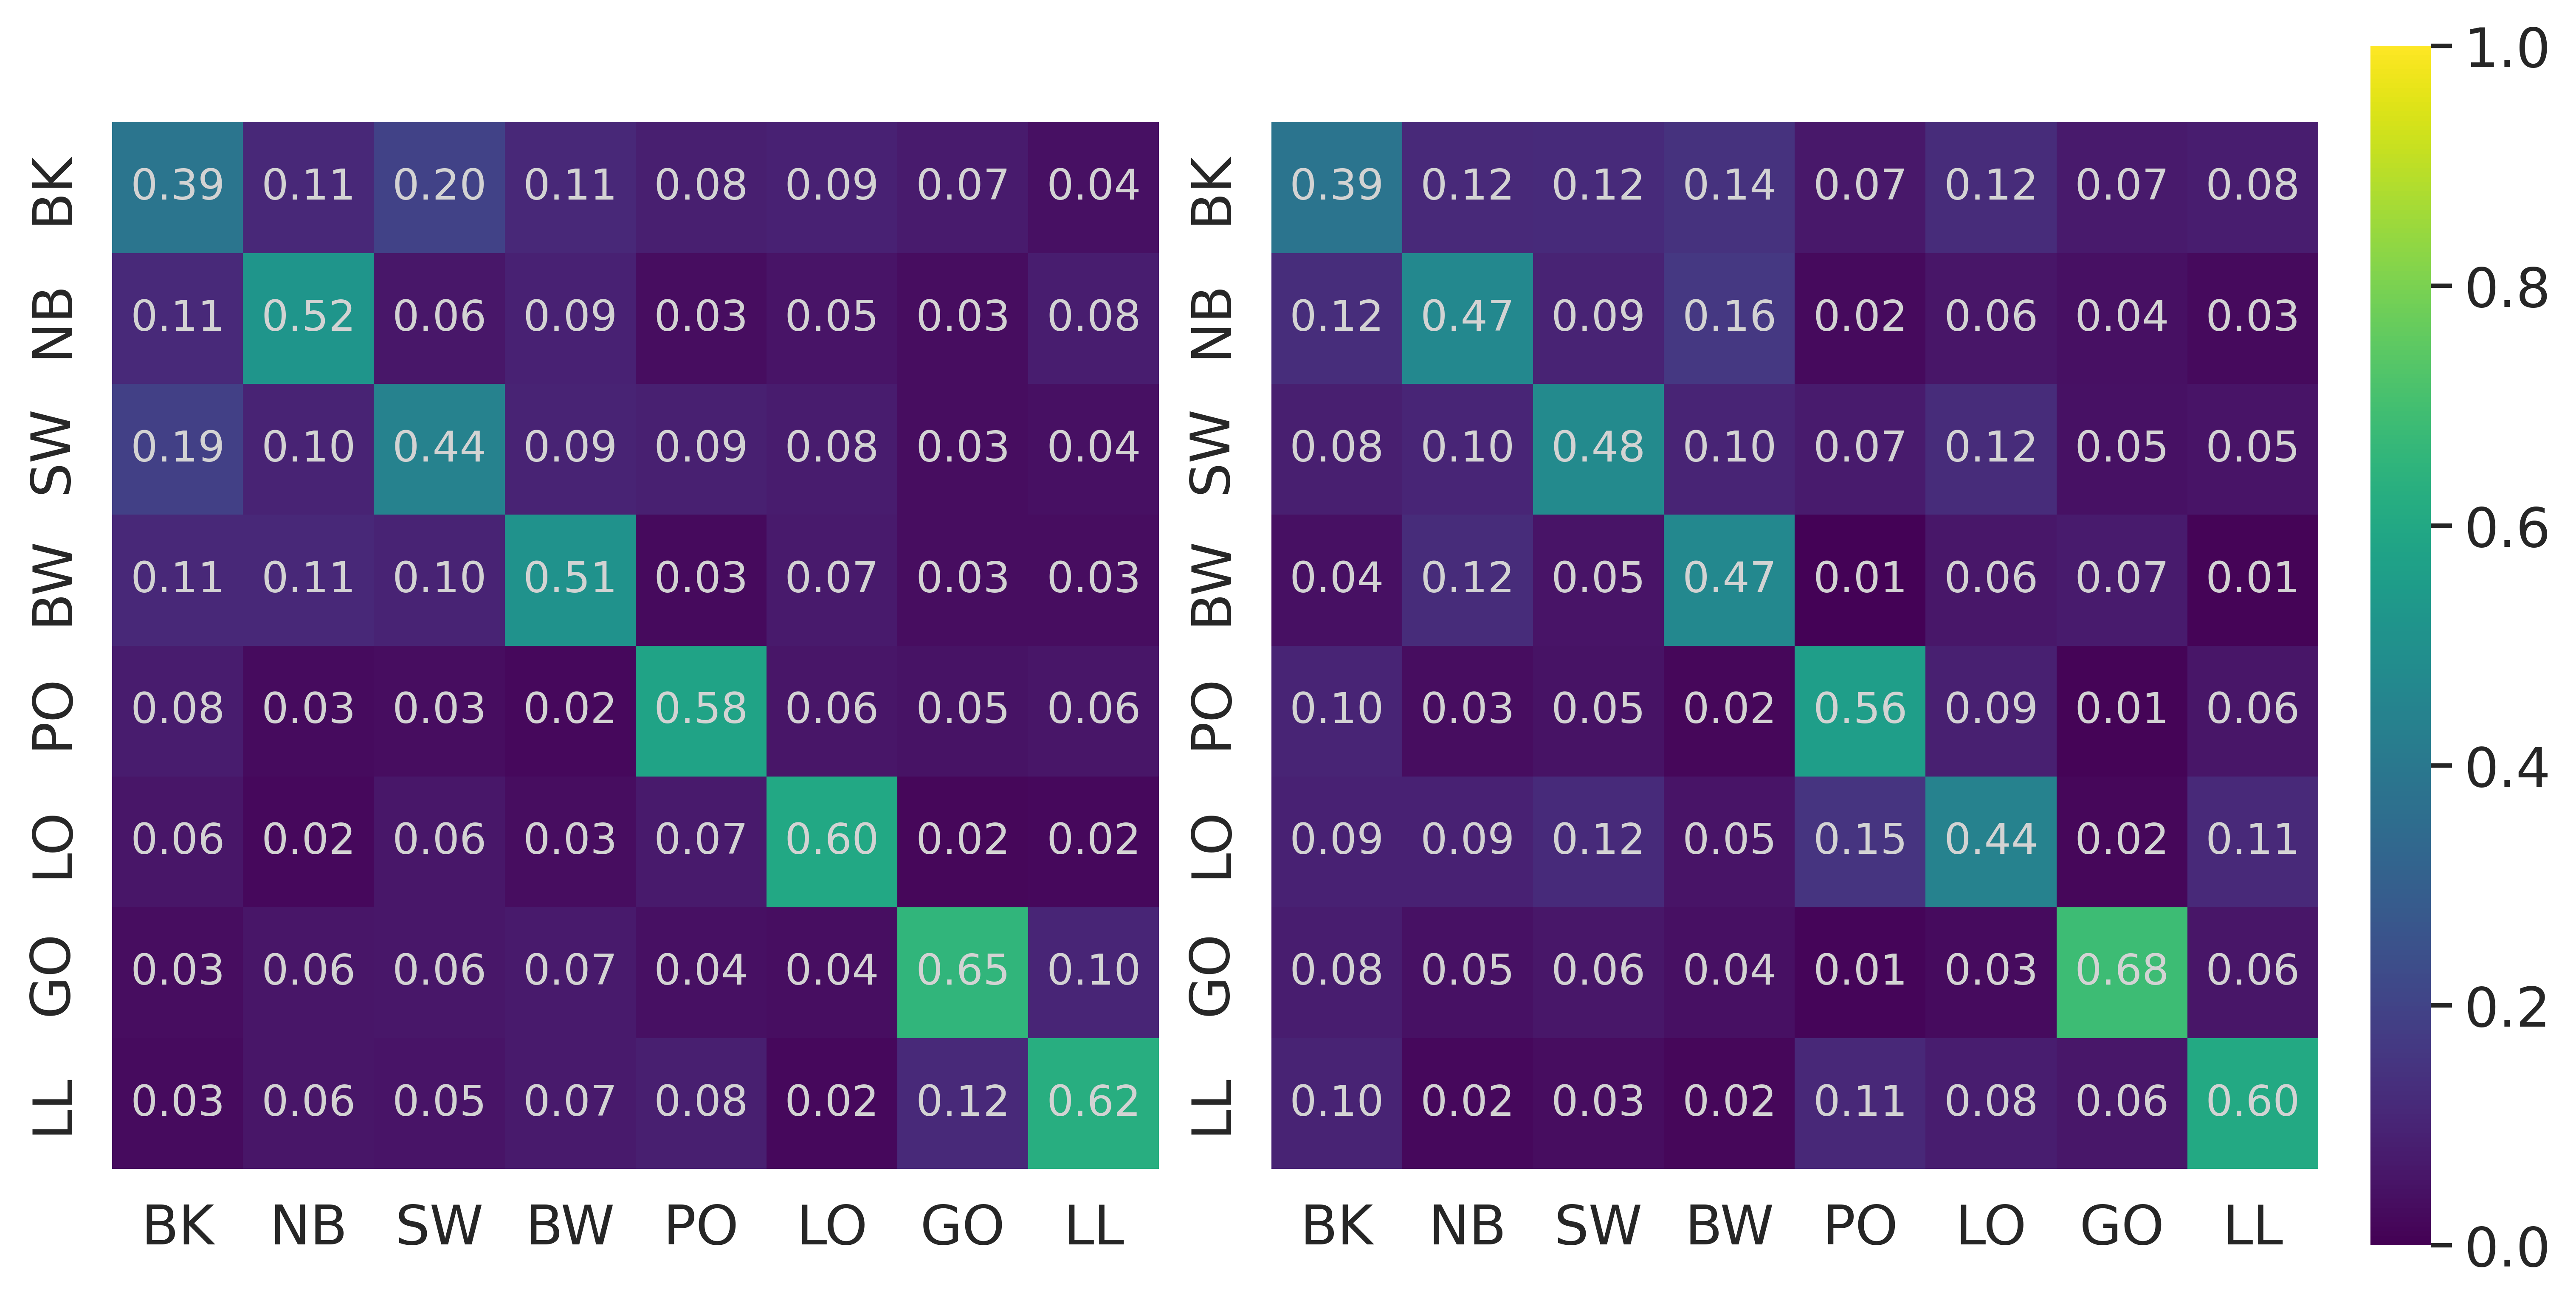

In [457]:


save = False
show = 'precision'

###################################################################################################################

#Evaluate
labels = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL']
cry_y_pred = cry_model.predict(cry_X_test)
USV_y_pred = USV_model.predict(USV_X_test)

#set up the axes for plot
fig, axes = plt.subplots(nrows = 1, 
                         ncols = 2, 
                         figsize = [10,5], 
                         constrained_layout=True, 
                         dpi=600)

if show == 'precision':
    cry_cm = confusion_matrix(cry_y_test,cry_y_pred, labels = labels, normalize = 'pred')
    USV_cm = confusion_matrix(USV_y_test,USV_y_pred, labels = labels, normalize = 'pred')
    
elif show == 'recall':
    cry_cm = confusion_matrix(cry_y_test,cry_y_pred, labels = labels)
    USV_cm = confusion_matrix(USV_y_test,USV_y_pred, labels = labels)
    

#normalize by row sum
cry_cm_df = pd.DataFrame(cry_cm, columns=labels, index=labels)
#cry_cm_df = cry_cm_df.div(cry_cm_df.sum(axis=0), axis=1)

USV_cm_df = pd.DataFrame(USV_cm, columns=labels, index=labels)
#USV_cm_df = USV_cm_df.div(USV_cm_df.sum(axis=0), axis=1)

sns.set(font_scale=1.4) # for label size

#plot cry confusion matrix
sns.heatmap(cry_cm_df, 
            annot=True, 
            annot_kws={"size": 12, "color":'lightgrey'}, 
            fmt=".2f",
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True, 
            ax = axes[0], 
            cbar=False) 

#plot USV confusion matrix
sns.heatmap(USV_cm_df, 
            annot=True, 
            annot_kws={"size": 12, "color":'lightgrey'}, 
            fmt=".2f",
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True, 
            ax = axes[1], 
            cbar=True) 

cry_report = classification_report(cry_y_test, cry_y_pred, output_dict=True)
USV_report = classification_report(USV_y_test, USV_y_pred, output_dict=True)

#if save:
#     plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'+voc_type+'_RF_1000_trees_20221012.jpeg', dpi=600)
#     plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'+voc_type+'_RF_1000_trees_20221012.pdf')


## train model to predict species from varying amounts of training examples

In [27]:

#evaluate machine learning models trained on varying amounts of data

#features for prediction
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
features_for_training = params_dict['figure_2_panels_AB']['features']

#species
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']

#sample sizes to train on for each species
sample_sizes = [50, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

print('cry')
cry_prediction_df = machinelearning.get_metric_by_sample_size(
                                                              voc_type = 'cry', 
                                                              voc_df = all_annotations, 
                                                              sample_sizes = sample_sizes,
                                                              features = features_for_training, 
                                                              random_state = 123456, 
                                                              test_size = 0.2, 
                                                              target ='species', 
                                                              n_estimators = 100)
print('USV')
USV_prediction_df = machinelearning.get_metric_by_sample_size(
                                                              voc_type = 'USV',
                                                              voc_df = all_annotations, 
                                                              sample_sizes = sample_sizes,
                                                              features = features_for_training, 
                                                              random_state = 123456, 
                                                              test_size = 0.2, 
                                                              target ='species', 
                                                              n_estimators = 100)

evaluation_df = pd.concat([cry_prediction_df, USV_prediction_df])

print('done.')

cry
training random forest on 50 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 200 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 400 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 600 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 800 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 1000 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 1200 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 1400 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 1600 vocalizations.
	sampling data...
	training model...
	evaluating model...
training random forest on 1800 vocalizations.
	sampling data...
	t

### plot colored by species (not in a figure)

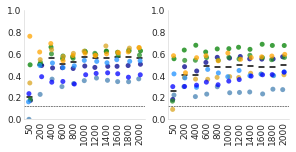

In [35]:


save=False


############################################################################################################

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'
version = '20221012_v1'



############################################################################################################

ytick_length = 2
ytick_pad = 0.5
fontsize=9

sns.set_style("whitegrid", {'axes.grid' : False})
species_color_dict = {'BW':'darkblue',
              'NB': 'dodgerblue',
              'BK': 'steelblue',
              'SW': 'blue',
              'PO': 'orange',
              'LO': 'goldenrod',
              'GO': 'green',
              'LL': 'forestgreen',
              'MU': 'mediumspringgreen', 
              'MZ': 'turquoise'}

fig, ax = plt.subplots(ncols=2, 
                       nrows=1, 
                       constrained_layout=True, 
                       sharey=False, figsize = [4,2])


evaluation_df = evaluation_df.loc[evaluation_df['species'].isin(species_list)]
evaluation_df = evaluation_df.reset_index(drop=True)
metric = 'f1-score'

sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='cry'],
                     hue='species', 
                     palette=species_color_dict, 
                     ax=ax[0], alpha=.75, s=5)

sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='USV'],
                     hue='species', 
                     palette=species_color_dict, 
                     ax=ax[1], alpha=.75, s=5)


sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='cry'], 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax[0])

sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='USV'], 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax[1])

for i in [0,1]:
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_ylim([0,1])
    ax[i].legend([],[], frameon=False)
    
    ax[i].xaxis.set_tick_params(width=.5, rotation = 90, length = ytick_length, pad = ytick_pad)
    ax[i].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    ax[i].set_yticks([0,.2, .4, .6, .8, 1])
    ax[i].set_ylim([0,1])
    ax[i].axhline(y=(1/8), linestyle= 'dashed', color='black', linewidth=0.5)


    for axis in ['top','bottom','left','right']:
            ax[i].spines[axis].set_linewidth(.5)
    for label in (ax[i].get_yticklabels() + ax[i].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

sns.despine()

if save:
    save_name = ('_').join(['f1-scores_by_sample_size', version])
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    

## plot colored by vocalization type (Figure 2 Panel B)

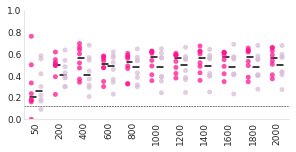

In [36]:
save=False

############################################################################################################

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'
version = '20221012_v1'
metric = 'f1-score'

############################################################################################################

ytick_length = 2
ytick_pad = 0.5
fontsize=9

voc_name_color_dict = {'cry': 'deeppink', 
               'USV': 'thistle', 
               'nan':'black'}


sns.set_style("whitegrid", {'axes.grid' : False})
species_color_dict = {'BW':'darkblue',
              'NB': 'dodgerblue',
              'BK': 'steelblue',
              'SW': 'blue',
              'PO': 'orange',
              'LO': 'goldenrod',
              'GO': 'green',
              'LL': 'forestgreen',
              'MU': 'mediumspringgreen', 
              'MZ': 'turquoise'}

fig, ax = plt.subplots(ncols=1, 
                       nrows=1, 
                       constrained_layout=True, 
                       sharey=False, figsize = [4,2])


model_df = evaluation_df.loc[evaluation_df['species'].isin(species_list)]
model_df = evaluation_df.reset_index(drop=True)


sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df,
                     jitter=False,
                     dodge=True,
                     hue='voc_type', 
                     palette=voc_name_color_dict, 
                     ax=ax, alpha=.75, s=5)

sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df, 
                     hue='voc_type',
                dodge=True,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax)




ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([0,1])
ax.legend([],[], frameon=False)

ax.xaxis.set_tick_params(width=.5, rotation = 90, length = ytick_length, pad = ytick_pad)
ax.yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax.set_yticks([0,.2, .4, .6, .8, 1])
ax.set_ylim([0,1])
ax.axhline(y=(1/8), linestyle= 'dashed', color='black', linewidth=0.5)


for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(.5)
for label in (ax.get_yticklabels() + ax.get_xticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(fontsize)

sns.despine()

if save:
    save_name = ('_').join(['precision_by_sample_size', version])
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    evaluation_df.to_csv(os.path.join(save_dir, 'training_set_comparison_evaluation.csv'), index=False)
    importances_df.to_csv(os.path.join(save_dir, 'training_set_comparison_importances.csv'), index=False)
    

# Train a model to predict vocalization type (cry, USV, or nonvocal) from features

## downsamlpe

In [479]:
#get the sampling parameters
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
seed = params_dict['figure_2_panels_AB']['sampling_seed']
num_to_sample = params_dict['figure_2_panels_AB']['num_to_sample']

#sample
print('sampling...')
ds_df = annotation.sample(seed, num_to_sample, annotations_df)

print('done.')

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
sampling...
done.


## add the annotated nonvocal sounds

In [480]:
#get annotated scratch sounds
nonvocal_df = pd.read_csv(annotations_20220321)
nonvocal_df['human_label'] = [i.split('_')[0] for i in nonvocal_df['source_file']]
nonvocal_df_scratch = nonvocal_df.loc[nonvocal_df['human_label'] == 'scratch']
nonvocal_df_scratch['species'] = [i.split('_')[1] for i in nonvocal_df_scratch['source_file']]
nonvocal_df_scratch = nonvocal_df_scratch[base_features+extra_features+['source_file','species', 'human_label']]

#merge with vocalizations
ds_df = ds_df.drop(columns = ['umap1', 'umap2', 'hdbscan_label', 'pup'])
assert sorted(nonvocal_df_scratch.columns) == sorted(ds_df.columns)
ds_df = pd.concat([ds_df, nonvocal_df_scratch]).reset_index(drop=True)

#make sure you have all of the labels
assert set(ds_df['human_label'].unique()) == set(['cry', 'USV', 'scratch'])

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [481]:
#show annotations by species 
print('annotations by species:\n')
for i in species_list:
    print(i,':', len(ds_df.loc[ds_df['species'] == i]))
    
# show annotations by label
print('\n')
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('USV:', len(ds_df.loc[ds_df['human_label'] == 'USV']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))

annotations by species:

BW : 4317
BK : 4022
NB : 4047
SW : 4012
PO : 4213
LO : 4061
GO : 4308
LL : 4254


annotations by label:

cry: 16000
USV: 16000
scratch: 1242


## select the features

In [482]:
#features for prediction
features_for_training = params_dict['supp_figure_2']['features']

#features and labels for training
features_targets = ds_df


## check for missing data and make sure there are no duplicates

In [483]:
assert features_targets[features_for_training].isnull().values.any() == False
print('No missing data')
    
assert features_targets.duplicated(subset=['source_file']).sum() == 0
print('No duplicate data')

No missing data
No duplicate data


## choose the model type and split the data

In [485]:
#get params
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
model_type = params_dict['supp_figure_2']['model_type']
split_random_state = params_dict['supp_figure_2']['split_random_state']
test_size = params_dict['supp_figure_2']['test_size']

#choose the data and the label and convert to numpy array
target = 'human_label'
X = np.array(df)
y = np.array(features_targets[target])

#split the data
print('splitting the data...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = split_random_state)

print('done.')

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
splitting the data...
done.


## train

In [486]:

#get training params
params_dict = parameters.load(save_dir = params_dict_path, save_name='parameters')
training_random_state = params_dict['supp_figure_2']['training_random_state']
n_estimators = params_dict['supp_figure_2']['training_n_estimators']
criterion = params_dict['supp_figure_2']['training_criterion']
bootstrap = params_dict['supp_figure_2']['training_bootstrap']
oob_score = params_dict['supp_figure_2']['training_oob_score']

#train
print('taining...')
voc_type_model = RandomForestClassifier(n_estimators = n_estimators, 
                                   criterion = criterion, 
                                   random_state = training_random_state, 
                                   bootstrap = bootstrap,
                                   oob_score = oob_score)
voc_type_model.fit(X_train, y_train)

#show out of bag score
print(voc_type_model.oob_score_)  
print('done.')

loaded parameters from:
	 /n/hoekstra_lab_tier1/Users/njourjine/public_repositories/peromyscus-pup-vocal-evolution/parameters/parameters
taining...
0.9959763847629075
done.


## evaluate (Supplementary Figure 2)

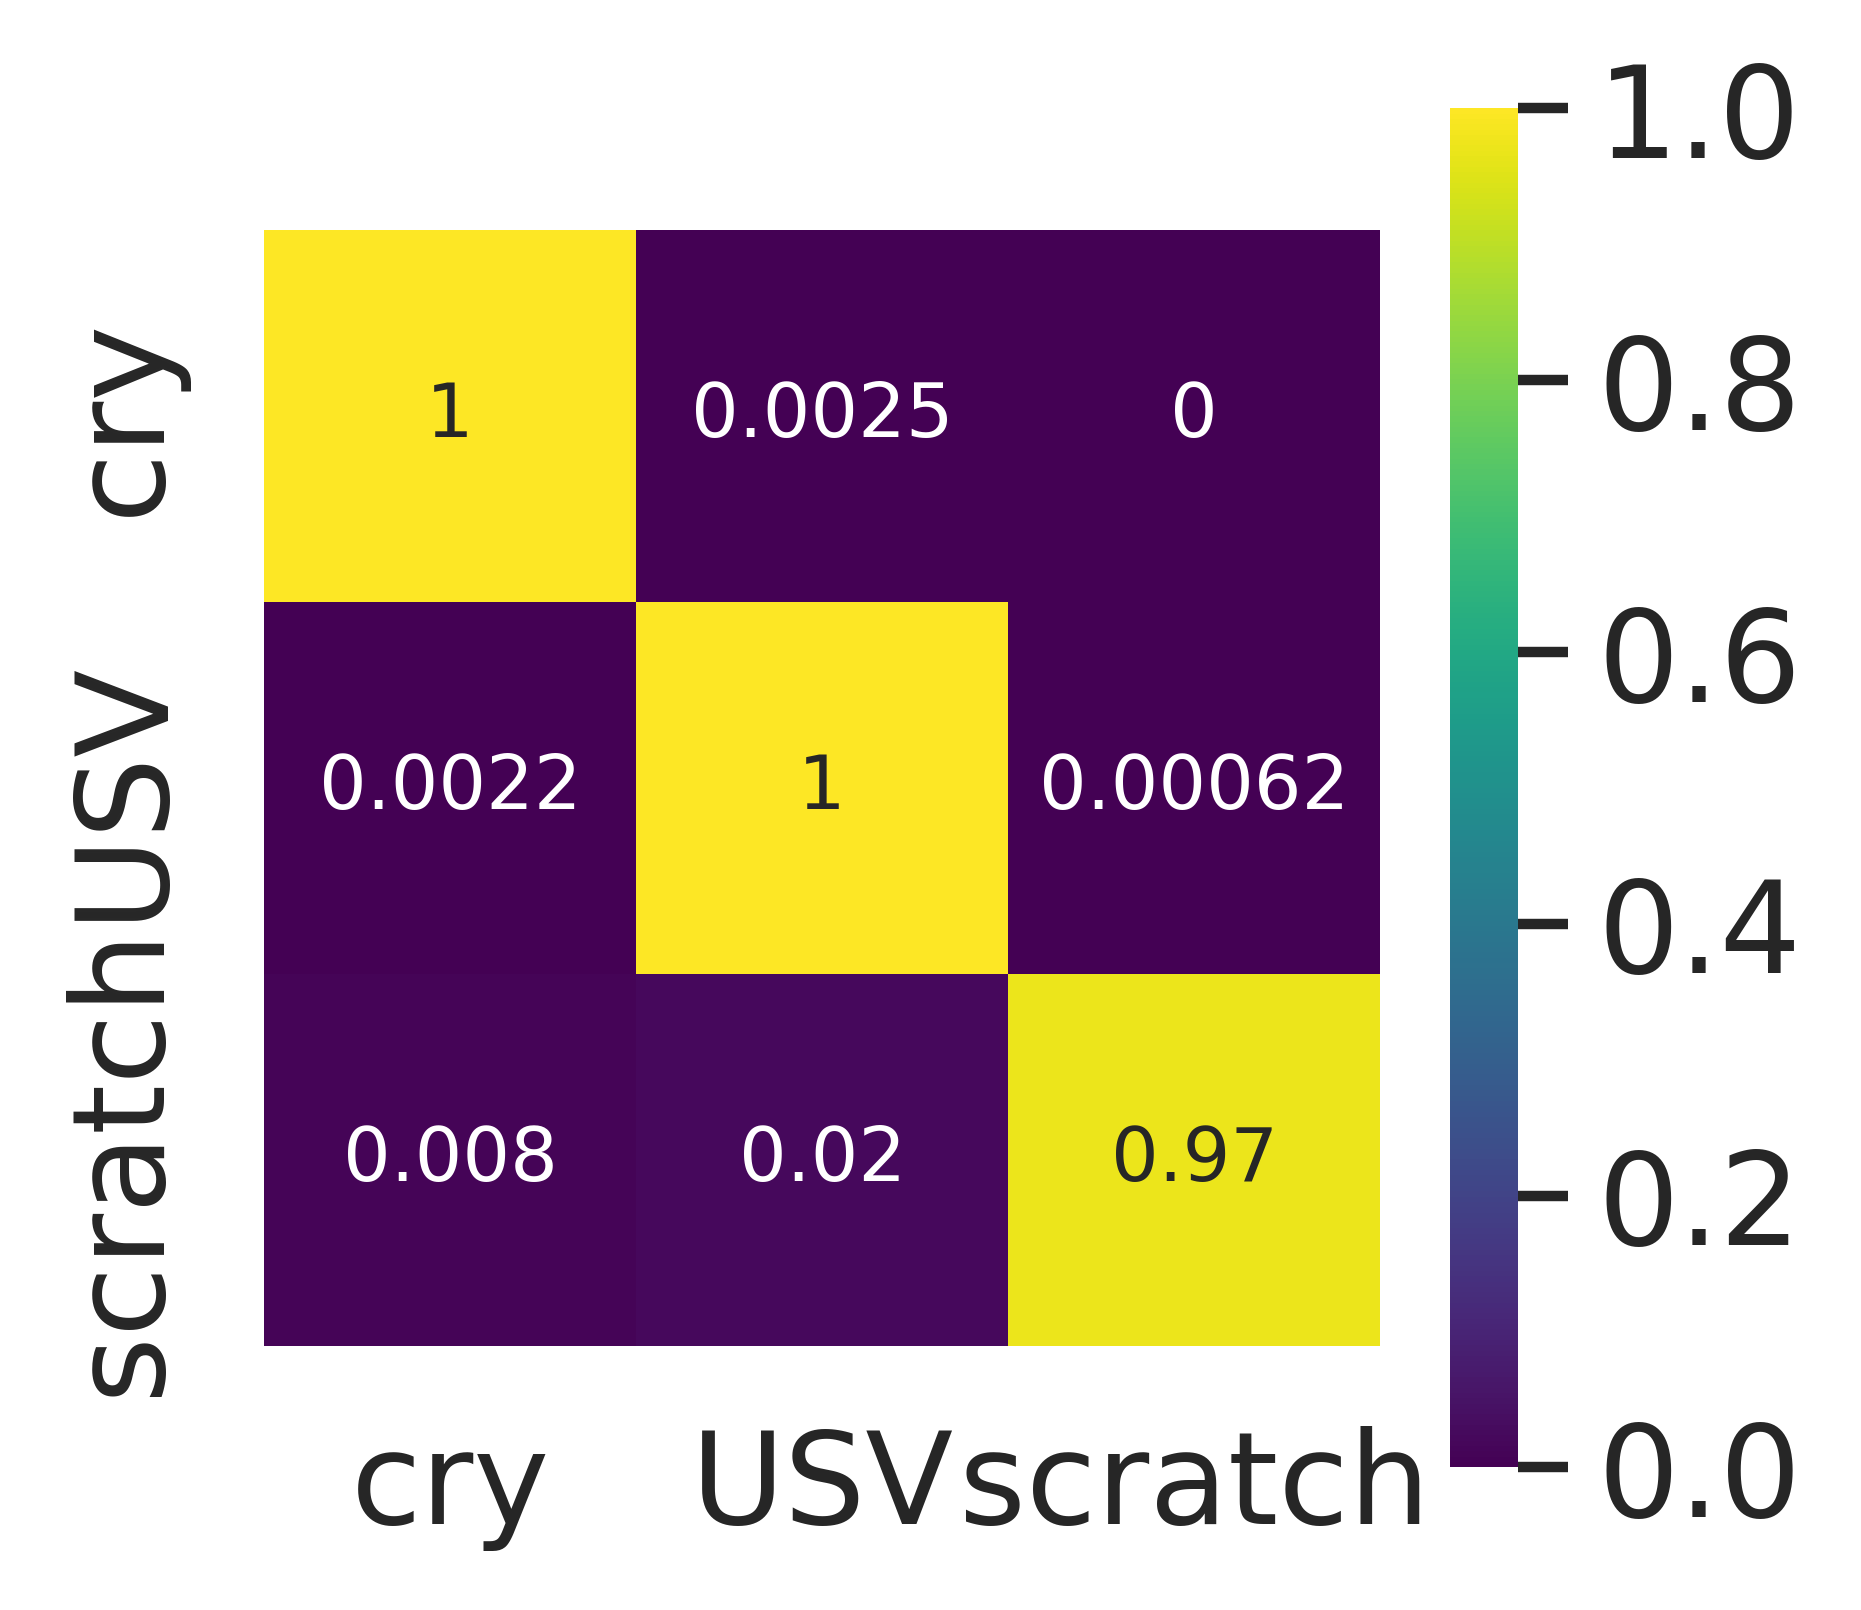

In [491]:
#Evaluate the model on held out data and plot a confusion matrix

save = False

###################################################################################################################

y_pred = voc_type_model.predict(X_test)
labels = ['cry', 'USV', 'scratch']
cm = confusion_matrix(y_test,y_pred, labels = labels, normalize='true')
fig = plt.figure(figsize=[3,3], dpi=600)

# #normalize by row sum
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
# cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, 
            annot=True, 
            annot_kws={"size": 9}, 
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True) # font size

classification_report(y_test, y_pred, output_dict=True)

if save:
    plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/panels/voctype_RF_20221015.jpeg', dpi=600)
    plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/panels/voctype_RF_20221015.svg') 

## save the model

In [492]:
# save model and training params
machinelearning.save(model = voc_type_model,
                     models_root = models_root, 
                     training_df = features_targets, 
                     feature_set = features_for_training, 
                     target = 'voc_type', 
                     test_size = test_size, 
                     n_estimators = n_estimators, 
                     criterion = criterion, 
                     split_random_state = split_random_state,
                     training_random_state = training_random_state,
                     model_type = model_type,
                     bootstrap = bootstrap, 
                     oob_score = USV_model.oob_score_)

model and training parameters will be saved to... /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230131_144546/
continue? y/ny
made a directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230131_144546/
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230131_144546/random_forest_20230131_144546_params
saved model to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20230131_144546/random_forest_20230131_144546_voc_type_model.pkl
done.
